In [5]:
!pip install pandas matplotlib scipy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 3.8 MB/s eta 0:00:00a 0:00:01m

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd

df = pd.read_csv('data/df_train.csv') 
df.info()

In [ ]:
df.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105565 entries, 0 to 105564
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   user_id                        105565 non-null  int64  
 1   nm_id                          105565 non-null  int64  
 2   CreatedDate                    105565 non-null  object 
 3   service                        105565 non-null  object 
 4   total_ordered                  105565 non-null  int64  
 5   PaymentType                    105565 non-null  object 
 6   IsPaid                         105565 non-null  bool   
 7   count_items                    105565 non-null  int64  
 8   unique_items                   105565 non-null  int64  
 9   avg_unique_purchase            105565 non-null  float64
 10  is_courier                     105565 non-null  int64  
 11  NmAge                          105565 non-null  int64  
 12  Distance                      

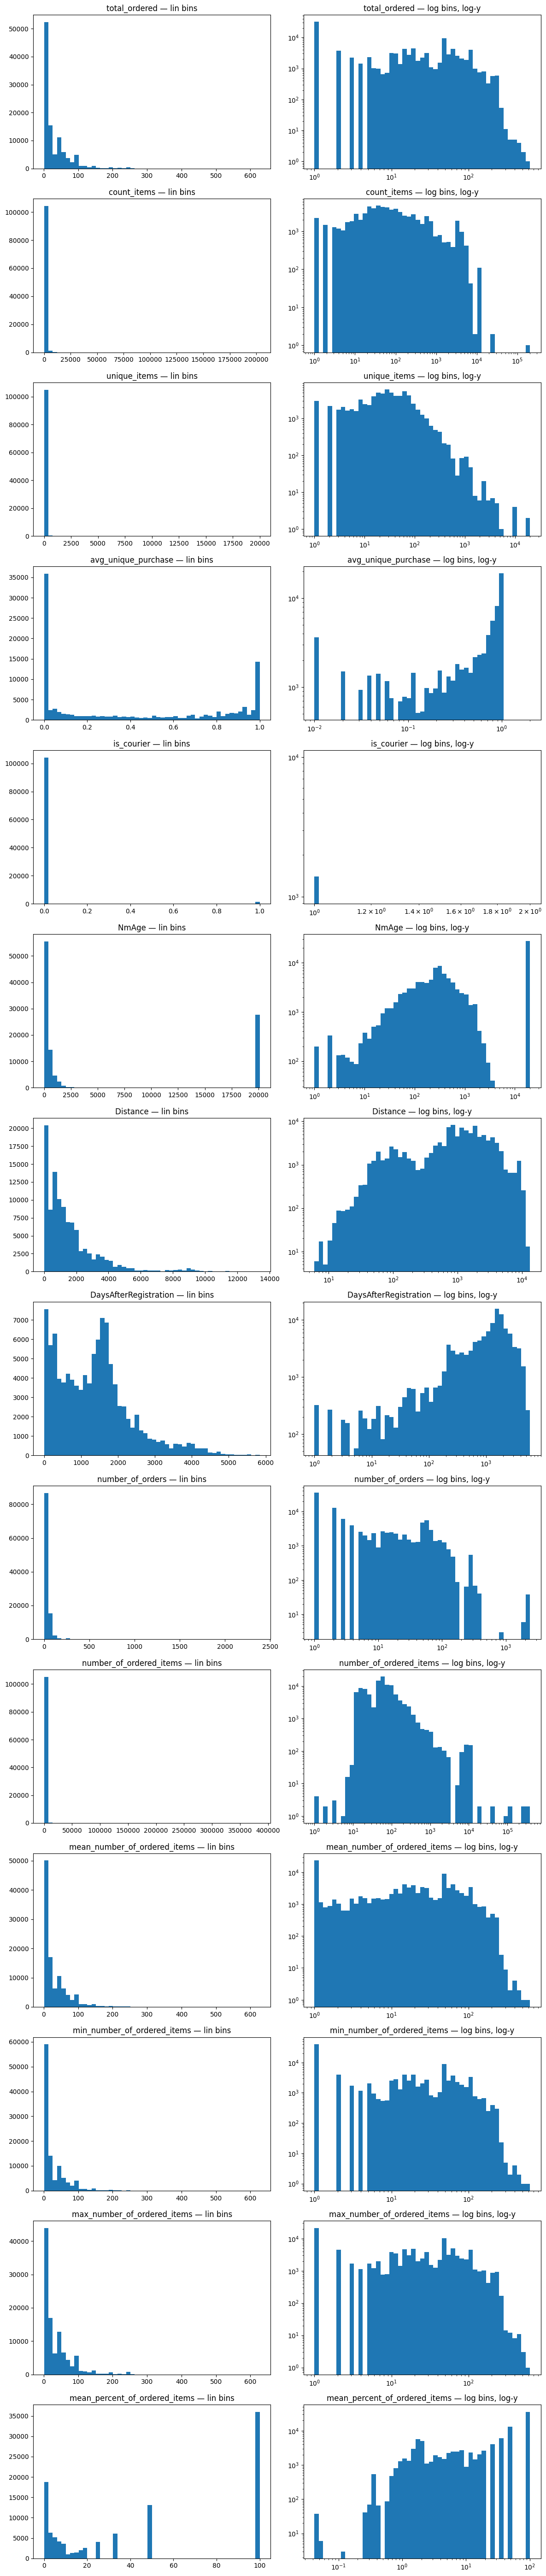

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#plt.style.use('seaborn-whitegrid')

# Выбираем числовые колонки, без ID/таргета
numeric_cols = [
    col for col in df.select_dtypes(['int64','float64']).columns
    if col not in ['user_id','nm_id','target']
]

# Функция для лог-бинов
def make_log_bins(series, bins=50):
    mn = series[series>0].min()
    mx = series.max()
    return np.logspace(np.log10(mn), np.log10(mx+1), bins)




# Отдельно: гистограммы (линейная и лог-бинны)
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(12, 4*len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    arr = df[col].dropna()
    # Линейная гист
    axes[i,0].hist(arr, bins=50)
    axes[i,0].set_title(f'{col} — lin bins')
    # Лог-бинны
    if (arr>0).any():
        axes[i,1].hist(arr[arr>0], bins=make_log_bins(arr), log=True)
        axes[i,1].set_xscale('log')
        axes[i,1].set_title(f'{col} — log bins, log-y')
    else:
        axes[i,1].text(0.5,0.5,'no positive values',ha='center')
        axes[i,1].set_title(f'{col} — log bins')
plt.tight_layout()
plt.show()


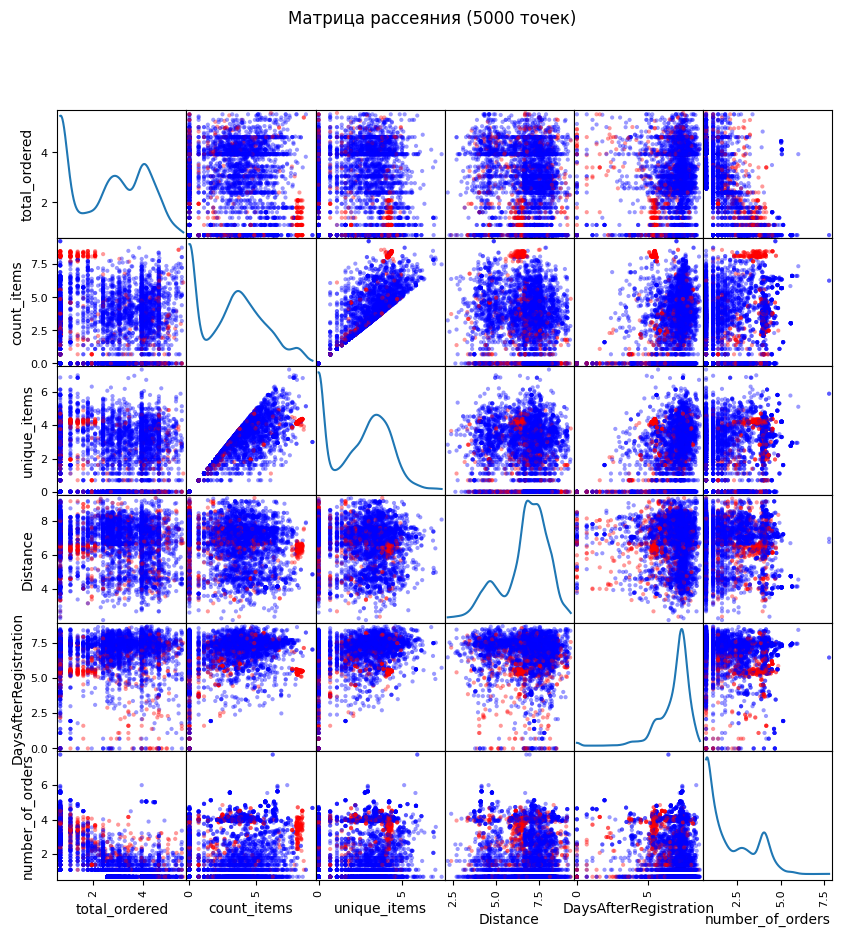

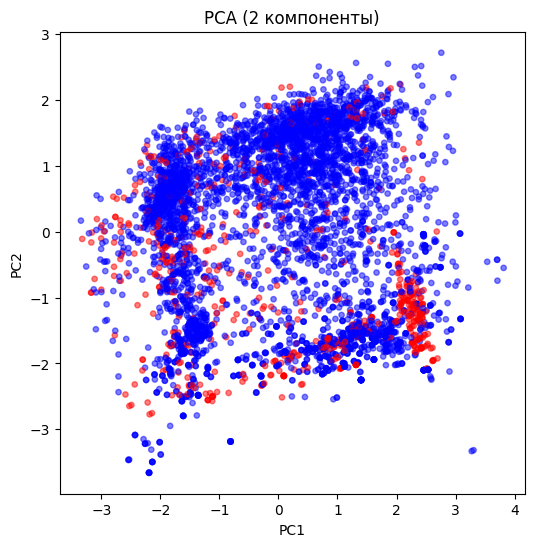

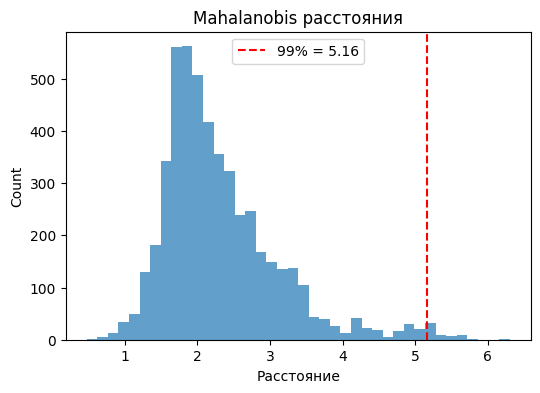

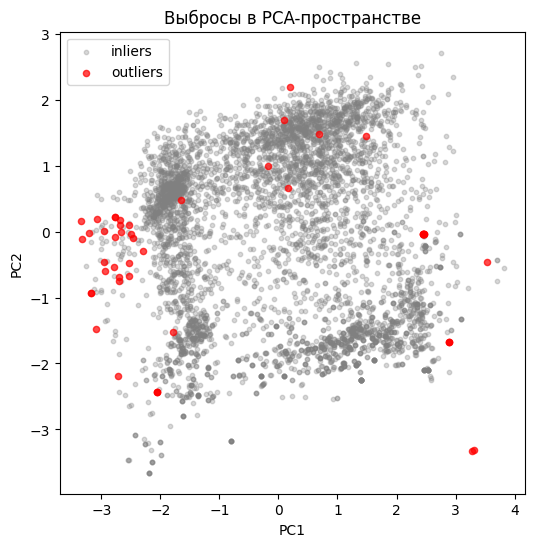

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
from scipy import linalg

df = pd.read_csv('data/df_train.csv')

cols = ['total_ordered', 'count_items', 'unique_items', 'Distance', 'DaysAfterRegistration', 'number_of_orders']
logd = np.log1p(df[cols])
col_target = df['target'].map({0:'blue',1:'red'})

sample = logd.sample(5000, random_state=42)
colors = df.loc[sample.index, 'target'].map({0:'blue',1:'red'})

scatter_matrix(sample, diagonal='kde', alpha=0.4, figsize=(10,10), color=colors)
plt.suptitle('Матрица рассеяния (5000 точек)')
plt.show()

X = StandardScaler().fit_transform(sample)
pc = PCA(2).fit_transform(X)
plt.figure(figsize=(6,6))
plt.scatter(pc[:,0], pc[:,1], c=colors, alpha=0.5, s=15)
plt.title('PCA (2 компоненты)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

cov = np.cov(X, rowvar=False)
inv_cov = linalg.inv(cov)
mean = X.mean(axis=0)
md = np.array([mahalanobis(x, mean, inv_cov) for x in X])
thr = np.percentile(md, 99)

plt.figure(figsize=(6,4))
plt.hist(md, bins=40, alpha=0.7)
plt.axvline(thr, color='red', linestyle='--', label=f'99% = {thr:.2f}')
plt.title('Mahalanobis расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Count')
plt.legend()
plt.show()

out = md > thr
plt.figure(figsize=(6,6))
plt.scatter(pc[~out,0], pc[~out,1], c='grey', alpha=0.3, s=10, label='inliers')
plt.scatter(pc[out,0], pc[out,1], c='red', alpha=0.7, s=20, label='outliers')
plt.title('Выбросы в PCA-пространстве')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()
